# The EOS from perturbative QCD (pQCD)

## Author: Alexandra Semposki

### Date last edited: 29 March 2024

This annotated Jupyter notebook walks us through the calculation of perturbative QCD (pQCD) using the general form of the pressure, $P(\mu)$, given in [Gorda et al. (2023)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.131.181902), in the Supplemental Material, up to and including N$^{2}$LO. This notebook generates some of the figures in our paper, by A. Semposki, C. Drischler, R. J. Furnstahl, J. A. Melendez, and D. R. Phillips, for the EOS of pQCD (Section II B), and generates input data for the model mixing in Secs. III and IV.

The first half of this notebook calculates the pressure with respect to the chemical potential, and shows results when BUQEYE truncation error methods are applied to estimate the uncertainties from higher order terms. The second half of the notebook then performs the transformation of this equation to $P(n)$ using the well-known example of Kohn, Luttinger, and Ward (henceforth referred to here as the "KLW inversion" or "KLW method"). The details of the theory behind this method can be found in Fetter and Walecka's "Quantum Theory of Many Particle Systems", or in the original papers, found [here](https://journals.aps.org/pr/abstract/10.1103/PhysRev.118.41) and [here](https://journals.aps.org/pr/abstract/10.1103/PhysRev.118.1417). After calculating $P(n)$ up to the same order, we compute the sound speed squared, $c_{s}^{2}(n)$.

This notebook can be easily altered to reflect the EOS from pQCD for asymmetric nuclear matter, and also can be modified to include the recent results from [Gorda et al. (2023)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.131.181902) at N$^{3}$LO, if desired. 

#### Table of contents

1. [Calculation of $P(\mu)$](#calc_p_mu)
2. [Calculation of $P(n)$](#calc_p_n)
3. [Calculation of the relative error](#calc_rel_err)
3. [Generating the Fermi gas pressure, $P_{FG}(n)$](#pfg)
4. [Computing the sound speed squared, $c_{s}^{2}(n)$](#cs2) 

---

## Setting up the calculation

First, we import all necessary packages.

In [1]:
# import packages
%load_ext autoreload
%autoreload 2

import gsum as gm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
import numpy as np
import numdifftools as ndt
import scipy.stats as stats
from scipy.optimize import fsolve
import os
from IPython.display import Image
import sys
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

sys.path.append('../src')
sys.path.append('../data')

import scipy.integrate as sc
import scipy.optimize as opt
from scipy.interpolate import interp1d
from collections import defaultdict

from pqcd_reworked import PQCD
from truncation_error import Truncation

from scripts import *
setup_rc_params()

%matplotlib inline

edgewidth = 0.3

sys.path.append('../nuclear-matter-convergence/')
from nuclear_matter.graphs import *
from nuclear_matter import lighten_color

In [2]:
# define order list now
orders = [0,1,2]

# plotting assistance
order_labels = ['LO', 'NLO', 'N$^{2}$LO', 'N$^{3}$LO']
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.55) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

---

## Calculation of $P(\mu)$ <a id="calc_p_mu"></a>

Here we calculate the scaled pressure in terms of the quark chemical potential $\mu_q \equiv \mu$, since we will be needing this quantity for the model mixing step of this work. 

We begin by looking at the coefficients of the $P(\mu)$ series to see what the interpolation will look like.

In [3]:
n0 = 0.164   # fm-3

In [20]:
# first choose a chemical potential range (the one below corresponds to the number density
# that we will be using later)
x = np.linspace(0.4, 1.32, 250)  # mu_q
x_B = 3.0*x  # mu_B

X = x[:, None]  # make a 2D version of x to match the input data structure from scikit learn
n_orders = 3    # Here we examine the case where we have info on two non-trivial orders (1,2)
orders = np.arange(0, n_orders)

# try only using the NLO, N2LO coefficients
excluded = [0]
orders_mask = ~ np.isin(orders, excluded)   # masking orders to exclude them from training

# call the PQCD class from the pqcd_reworked.py file
pqcd = PQCD(X=1,Nf=2)

# define the coefficients using the coefficient functions in 
# the pQCD class 
coeffs = np.array([pqcd.c_0(x), pqcd.c_1(x), pqcd.c_2(x)]).T 

Now we call the `Truncation()` class, and send it the chemical potential, number of orders, order array, function for yref (for us, found in the pQCD class), expansion parameter (for us, also found in the pQCD class), coefficient array, and the mask such that we only train on the selected orders. 

In [21]:
# using the classes to get the results
# employs gsum for interpolation and truncation GPs
# send the orders and mask into the truncation class
trunc = Truncation(x, x_FG=None, norders=3, orders=orders, yref=pqcd.yref, \
                   expQ=pqcd.expQ, coeffs=coeffs, mask=orders_mask)

Now we plot the curves and coefficients.

Text(0.5, 0, '$x$')

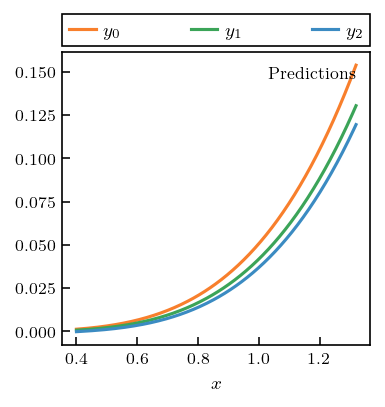

In [22]:
top_legend_kwargs = dict(
    loc='lower left',
    bbox_to_anchor=(0, 1.02, 1, 0.5), ncol=4,
    borderpad=0.37,
    labelspacing=0.,
    handlelength=1.4,
    handletextpad=0.4, borderaxespad=0,
    edgecolor='k',
    mode='expand',
    fancybox=False
)

fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

for i, curve in enumerate(trunc.data.T):
    ax.plot(x, curve, label=r'$y_{}$'.format(i), c=colors[i])

ax.text(0.95, 0.95, 'Predictions', ha='right', va='top',
        transform=ax.transAxes)

legend = ax.legend(**top_legend_kwargs)

# Format
ax.set_xlabel(r'$x$')

Text(0.5, 0, '$\\mu_{q}$')

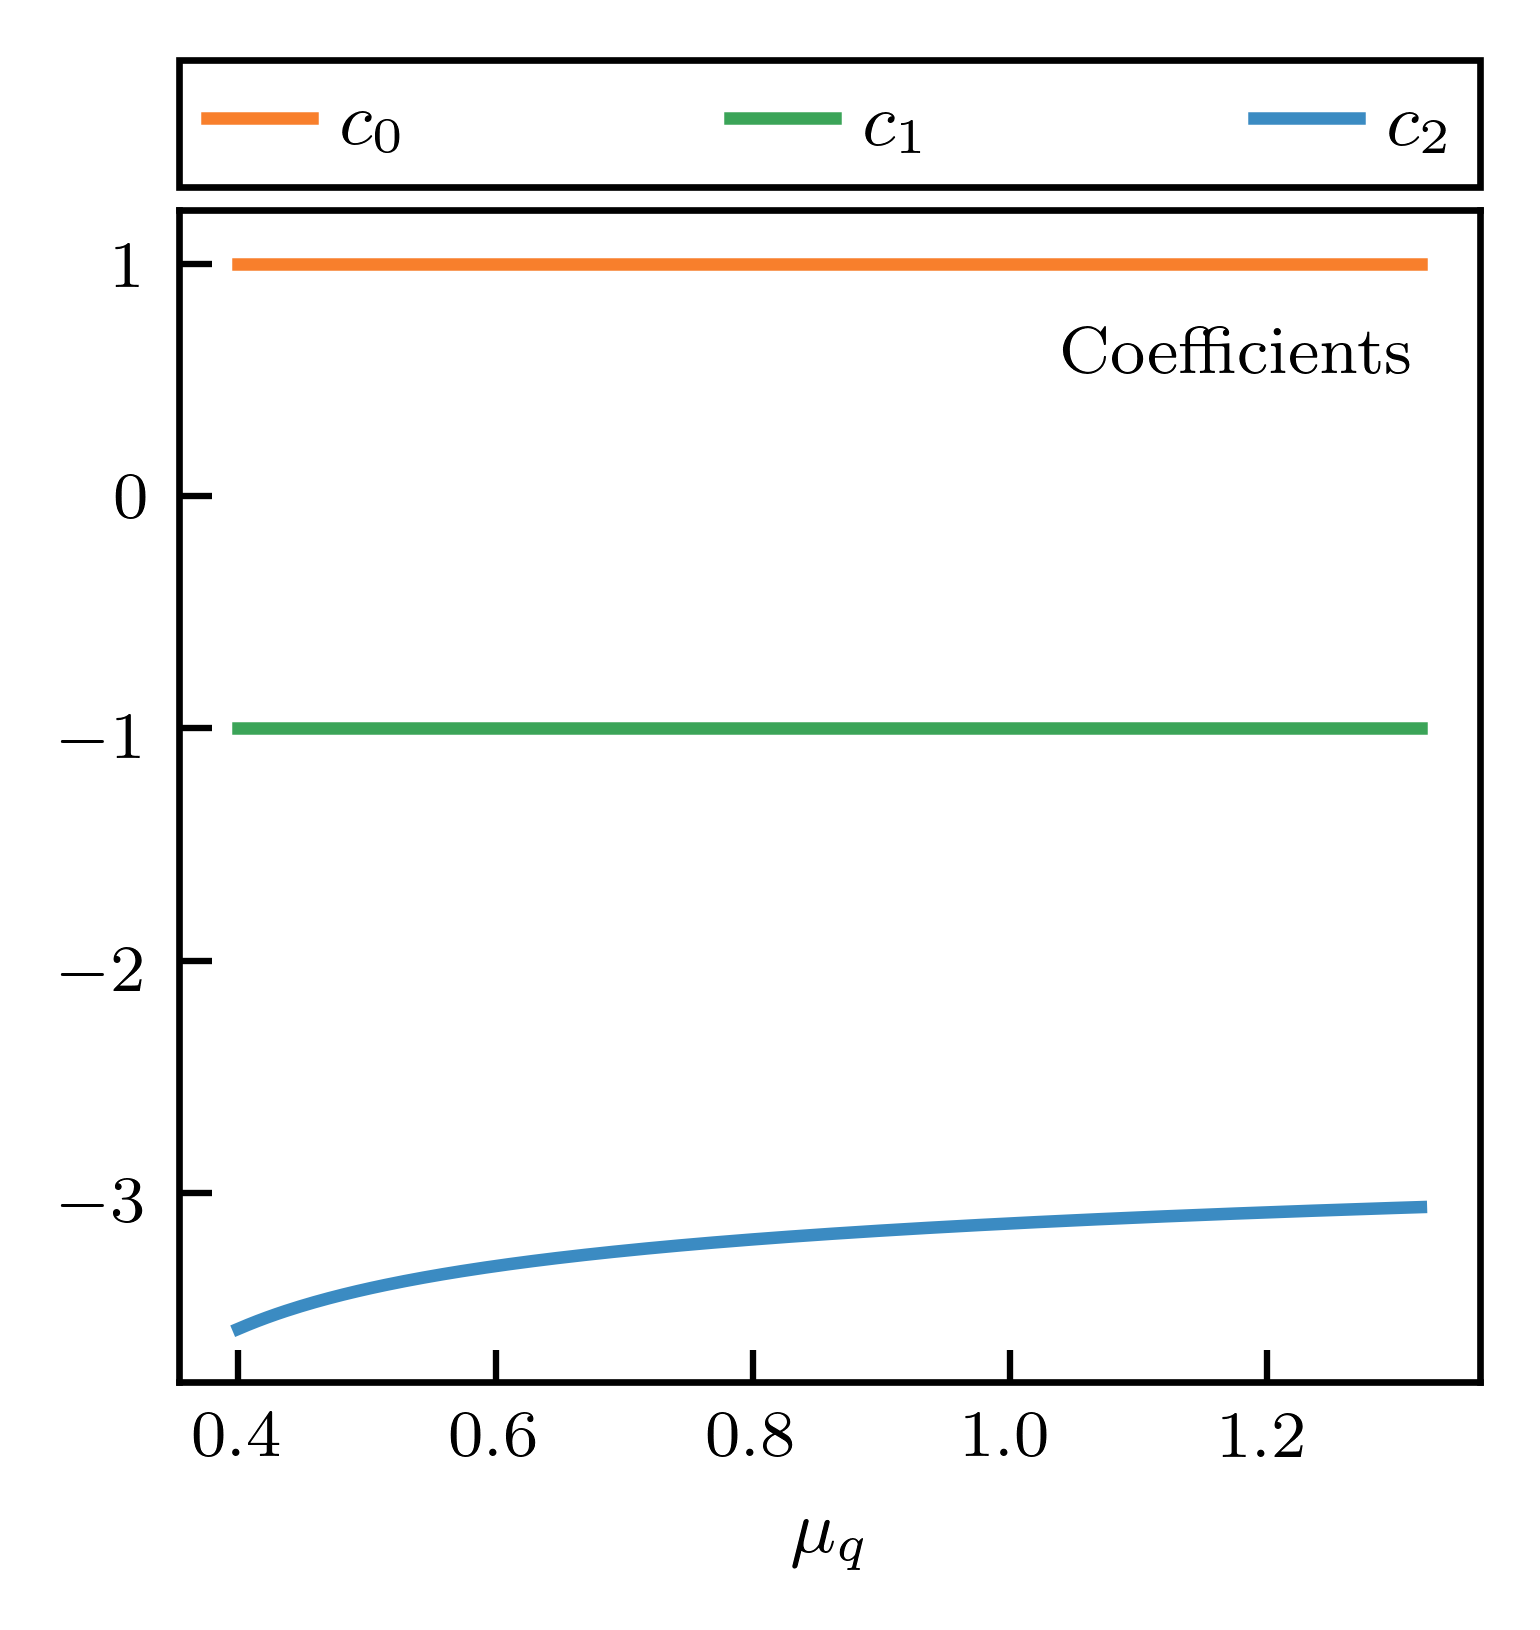

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6), dpi=600)

for i,n in enumerate(orders):
    ax.plot(x, trunc.coeffs[:, i], label=r'$c_{}$'.format(i), c=colors[i])

ax.text(0.95, 0.90, 'Coefficients', ha='right', va='top',
           transform=ax.transAxes)

legend = ax.legend(**top_legend_kwargs)

# Format
ax.set_xlabel(r'$\mu_{q}$')

Now we fit and predict using the GP class in `gsum` so that we can see what the interpolation will do once we call the actual `TruncationGP` class in `gsum`.

In [24]:
# now fit and predict with the GP (this is directly on the coefficients, so our diagnostics)
pred, std, underlying_std = trunc.gp_interpolation(center=0.0, sd=1.0)

RBF(length_scale=3.82)
7.561521733100215


Now we plot the coefficients that we trained on, and the overlaid GP results, so that we can see how the training did.

RBF(length_scale=3.82)
7.561521733100215
2.749822127538473


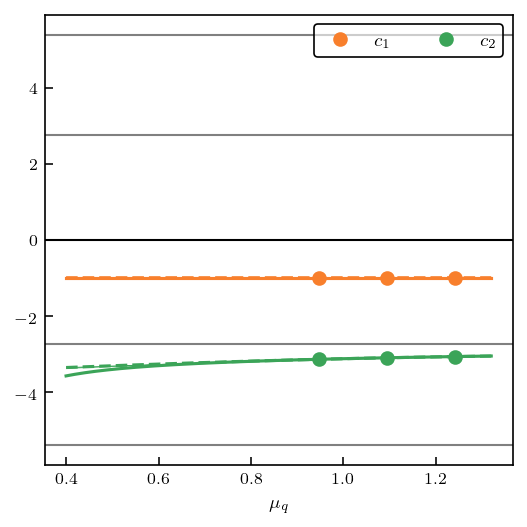

In [25]:
fig, ax = plt.subplots(figsize=(3.4, 3.4), dpi=150)
for i, n in enumerate(orders[1:]):
    ax.plot(x, pred[:, i], c=colors[i], zorder=i-5, ls='--')
    ax.plot(x, trunc.coeffs_trunc[:, i], c=colors[i], zorder=i-5)
  #  ax.plot(x, trunc.coeffs[:, i], c=colors[i], zorder=i-5)
    ax.plot(x[trunc.mask], trunc.coeffs_trunc[trunc.mask, i], c=colors[i], zorder=i-5, ls='', marker='o',
            label=r'$c_{}$'.format(n))
 #   ax.plot(x[trunc.mask], trunc.coeffs[trunc.mask, i], c=colors[i], zorder=i-5, ls='', marker='o',
 #         label=r'$c_{}$'.format(n))
    ax.fill_between(x, pred[:, i] + 2*std, pred[:, i] - 2*std, zorder=i-5,
                     facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=1)

print(trunc.gp_interp.kernel_)
print(trunc.gp_interp.cov_factor_)
print(np.sqrt(trunc.gp_interp.cov_factor_))

# Format
ax.axhline(1.96*underlying_std, 0, 1, c='gray', zorder=-10, lw=1)
ax.axhline(-1.96*underlying_std, 0, 1, c='gray', zorder=-10, lw=1)
ax.axhline(1.0*underlying_std, 0, 1, c='gray', zorder=-10, lw=1)
ax.axhline(-1.0*underlying_std, 0, 1, c='gray', zorder=-10, lw=1)
ax.axhline(0, 0, 1, c='k', zorder=-10, lw=1)
ax.set_xlabel(r'$\mu_{q}$')
ax.tick_params(which='minor', bottom=True, top=False)
ax.legend(ncol=2, borderaxespad=0.5, borderpad=0.4)

We then build the order-by-order data for the truncation GP to construct the truncation error bands at each order. Then we call the `truncation_error.py` function `uncertainties` and send it the data, expansion parameter, value for $y_{\textrm{ref}}$, and a very small nugget to help the Cholesky decomposition when fitting. We then print the lengthscale and value of the marginal variance, $\bar{c}^{2}$.

In [26]:
# data order-by-order P(mu) calculation
data_0 = pqcd.yref(X) * pqcd.c_0(x) 
data_1 = pqcd.yref(X) * (pqcd.c_0(x) + pqcd.c_1(x)*pqcd.expQ(X))
data_2 = pqcd.yref(X) * (pqcd.c_0(x) + pqcd.c_1(x)*pqcd.expQ(X) + pqcd.c_2(x)*pqcd.expQ(X)**2.0)

# compile the orders
data = np.array([data_0, data_1, data_2]).T

# feed to the TruncationGP class and get back the truncation errors (excluding c_0)
data, coeffs, std, cov_1 = trunc.uncertainties(data=data, expQ=pqcd.expQ, yref=pqcd.yref, sd=1.0, \
                                        excluded=[0], nugget=1e-09)
print(trunc.trunc_gp.coeffs_process.cov_factor_)

RBF(length_scale=3.82)
1e-09
7.570542715260585


Now we plot the results from the $P(\mu)$ truncation error analysis.

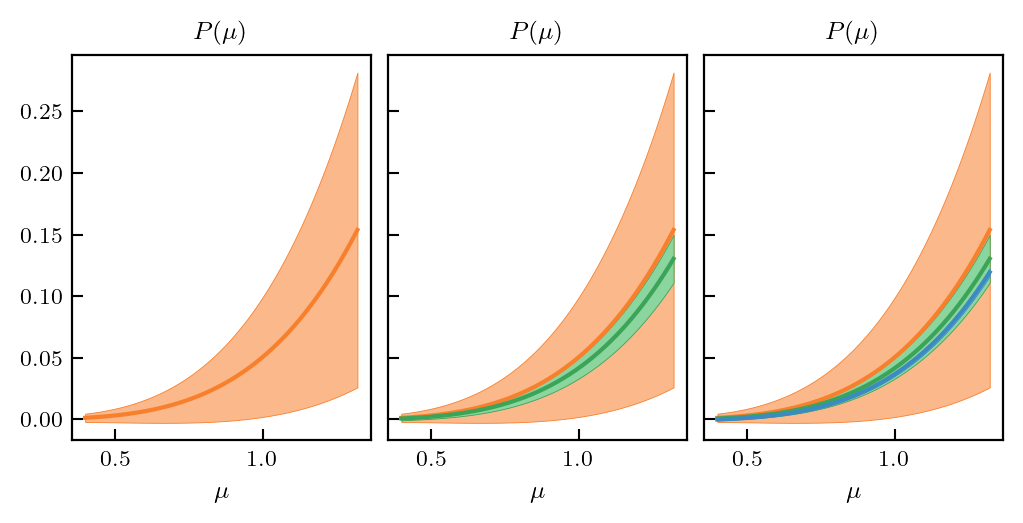

In [27]:
# plot the results here to check the class
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(5, 2.5), dpi=200)

for i, n in enumerate(orders):
    for j in range(i, 3):
        ax = axes.ravel()[j]
        ax.plot(x, data[:, i], zorder=i, c=colors[i])
        ax.fill_between(x, data[:, i] + 1.96*std[:,i], data[:, i] - 1.96*std[:,i],
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.set_xlabel(r'$\mu$')
    ax.set_title(r'$P(\mu)$')

Let's now scale the pressure results by the $y_{\textrm{ref}}$ result at each density---the Fermi gas pressure, $P_{FG}(\mu)$.

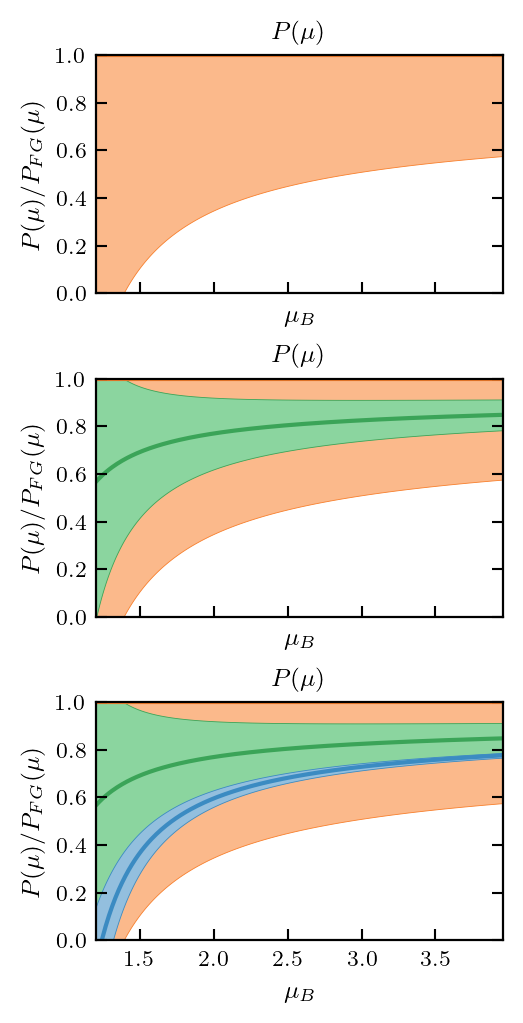

In [28]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(2.5, 5), dpi=200)

for i,n in enumerate(orders):
    for j in range(i, 3):
        ax = axes.ravel()[j]
        ax.plot(x_B, data[:, i]/pqcd.yref(X), zorder=i, c=colors[i])
        ax.fill_between(x_B, (data[:, i] + 1.0*std[:,i])/pqcd.yref(X), (data[:, i] - 1.0*std[:,i])/pqcd.yref(X),
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.set_ylim(0,1)
    ax.set_xlim(min(x_B), max(x_B))
    ax.set_xlabel(r'$\mu_{B}$')
    ax.set_ylabel(r'$P(\mu)/P_{FG}(\mu)$')
    ax.set_title(r'$P(\mu)$')
    ax.tick_params(right=True)

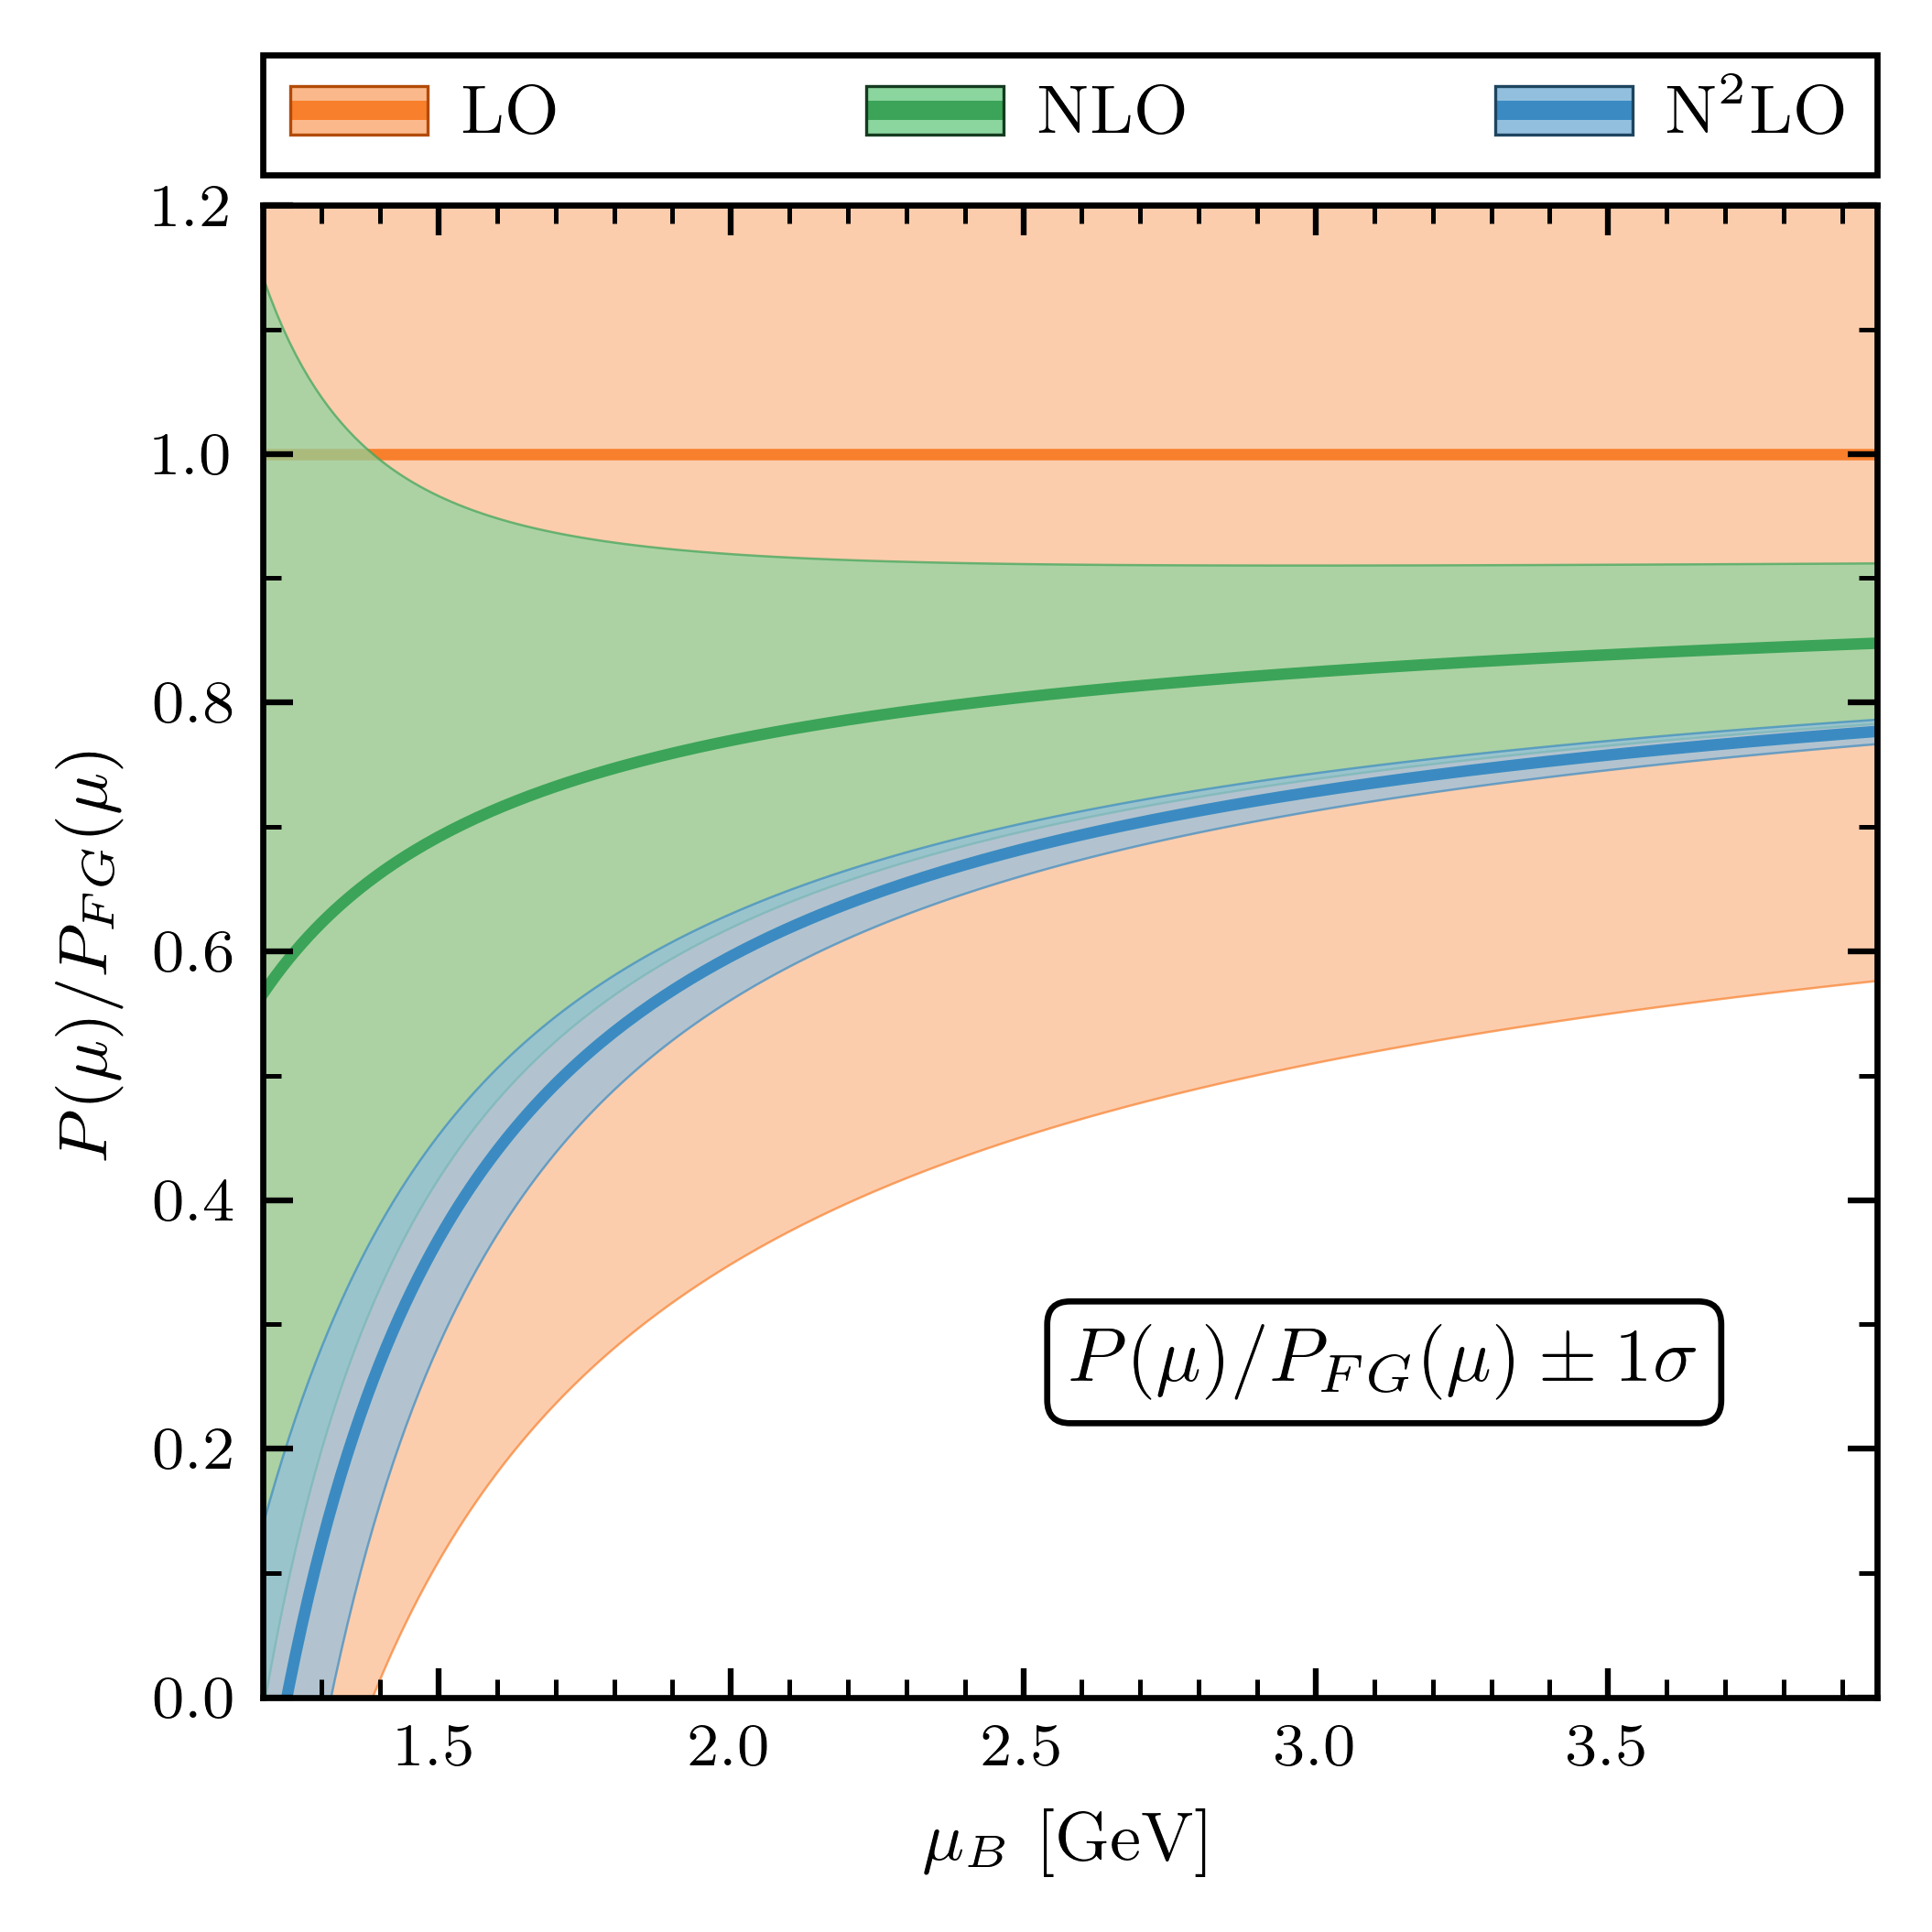

In [29]:
# Fig. 3 in our paper
labels = [r'LO', r'NLO', r'N$^{2}$LO']

fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
for i in range(3):
    ax.plot(3.0 * x, data[:, i]/pqcd.yref(X), zorder=i-1, c=colors[i])
    ax.fill_between(3.0 * x, (data[:, i] + 1.0*std[:,i])/pqcd.yref(X), \
                    (data[:, i] - 1.0*std[:,i])/pqcd.yref(X),
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=0.7)
    ax.set_ylim(0.0,1.2)
    ax.set_xlim(min(3.0 * x), max(3.0 * x))
    ax.set_ylabel(r'$P(\mu)/P_{FG}(\mu)$')
ax.set_xlabel(r'$\mu_{B}$ [GeV]')
title = r'$P(\mu)/P_{FG}(\mu) \pm 1\sigma$'
ax.text(
    0.50, 0.25, title, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, top=True, which='both')
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors)

#fig.savefig('pqcd_pressure_mu.png')

Now we look at the diagnostics to see how our fitting went. Of course it doesn't look perfect, but we are using quite flat coefficients, so this is not entirely unexpected. Nevertheless, our results are stable when we alter initial hyperparameter values, so we know that our results are consistent with respect to different initial prior values.

Number of points in training set: 3
Number of points in validation set: 2

Training set: 
 [[0.94682731]
 [1.09461847]
 [1.24240964]]

Validation set: 
 [[0.95421687]
 [1.13895582]]
2.751461923280165
1e-09
Calculated value : 4.817618091529464
Trained kernel:  RBF(length_scale=3.82)
Scale:  2.426561330287599
Condition number: 1714.2244495661057


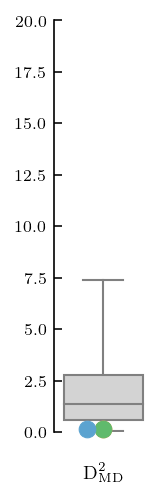

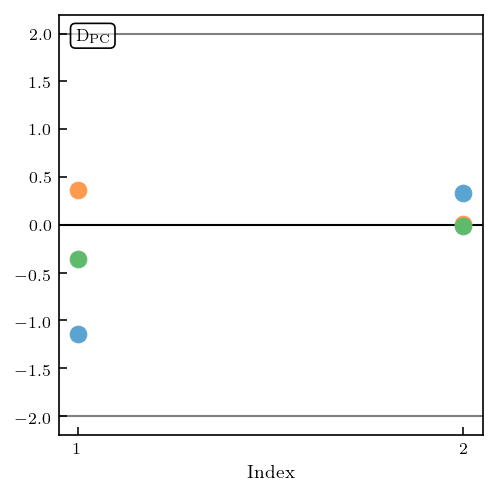

In [30]:
# call the diagnostics here to test before using on number density results
trunc.diagnostics(80, 50)

---

## Calculation of $P(n)$ <a id="calc_p_n"></a>

Now we want to obtain the pressure in terms of the baryon number density $n$, instead of the chemical potential. This means we need to employ the Kohn-Luttinger-Ward formalism mentioned at the top of this notebook. This formalism essentially rewrites the pressure at each order in terms of $\mu_{FG}(n)$, preserving thermodynamic consistency along the way. The code in the `pqcd_reworked.py` file does this for us, order-by-order.

### Setting up $n$ to obtain corresponding $\mu_{FG}(n)$

To pick the proper number density, we will first decide that range and then convert it to the corresponding chemical potential, as the code solves with respect to the quark chemical potential. 

__NOTE__: The warnings that will appear if one attempts to calculate under 0.4 GeV in the quark chemical potential are because this is approximately where $\alpha_{s}(\bar{\Lambda})$ becomes equal to 1.0. This is something make sure cut from our final results, but at present we calculate there since we need, at least for the pointwise mixing approach, data at the same points for both $\chi$EFT and pQCD, and we begin $\chi$EFT from there.

In [31]:
#n = np.linspace(11.2, 16.0, 300) # baryon number density from chiral EFT [fm^-3]
n = np.linspace(0.05, 16.4, 250)
dens = n

# convert this quark number density first
n_q = n*3.0  # n_q [fm^-3]

# convert to GeV^3 for mu_q
conversion_fm3 = ((1000.0)**(3.0))/((197.33)**(3.0)) # [fm^-3]  (do the opposite of this)
n_q = n_q/conversion_fm3  # [GeV^3]

# invert to get mu
_, mu_n, mu_FG = pqcd.inversion(n_mu=n_q)  # [GeV] # these are quark chemical potentials

# FG chemical potential
mU_FG = mu_FG[:,None]   # [GeV] 

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Now we wish to use the same kernel from when we trained on $P(\mu)$, but we want to predict at new points in $\mu_{FG}$. To do this, we give the truncation object the new linspace in $\mu_{FG}$ and plot the results for $P(n)$ and $P(n)/P_{FG}(n)$ in the following cells.

In [32]:
# use the same kernel as before (aka the exact same class), but predict at the new points in n (aka, mu_FG)
std_trunc_pn = np.zeros([len(mU_FG), n_orders])
cov_trunc_pn = np.zeros([len(mU_FG), len(mU_FG), n_orders])
for i, n in enumerate(orders):
        _, std_trunc_pn[:,n] = trunc.trunc_gp.predict(mU_FG, order=n, return_std=True, kind='trunc', \
                                                      pred_noise=True)
        _, cov_trunc_pn[:,:,n] = trunc.trunc_gp.predict(mU_FG, order=n, return_std=False, \
                                                        return_cov=True, kind='trunc', pred_noise=True)
        
# print the kernel parameters
print(trunc.trunc_gp.coeffs_process.kernel_)

# mask the inf values in std_trunc_pn
for j in range(len(orders)):
    for i in range(len(std_trunc_pn)):
        if np.isnan(std_trunc_pn[i,j]) == True or np.isinf(std_trunc_pn[i,j]) == True:
            std_trunc_pn[i,j] = 1e10

RBF(length_scale=3.82)


/Users/alexandra/Documents/EOSBMM/buqeyenm/notebooks/../src/pqcd_reworked.py:143: RuntimeWarning: invalid value encountered in log
  alpha_s = ((4.0*np.pi)/(self.beta0*ell)) * (1.0 - (2.0*beta1*np.log(ell))/(ell*self.beta0**2.0))
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/gsum/models.py:1340: RuntimeWarning: invalid value encountered in multiply
  return self.ref(X) * ratio_sum * coeff_mean


Text(0.1, 0.9, '$P(n)$ [MeV/fm$^{3}$]')

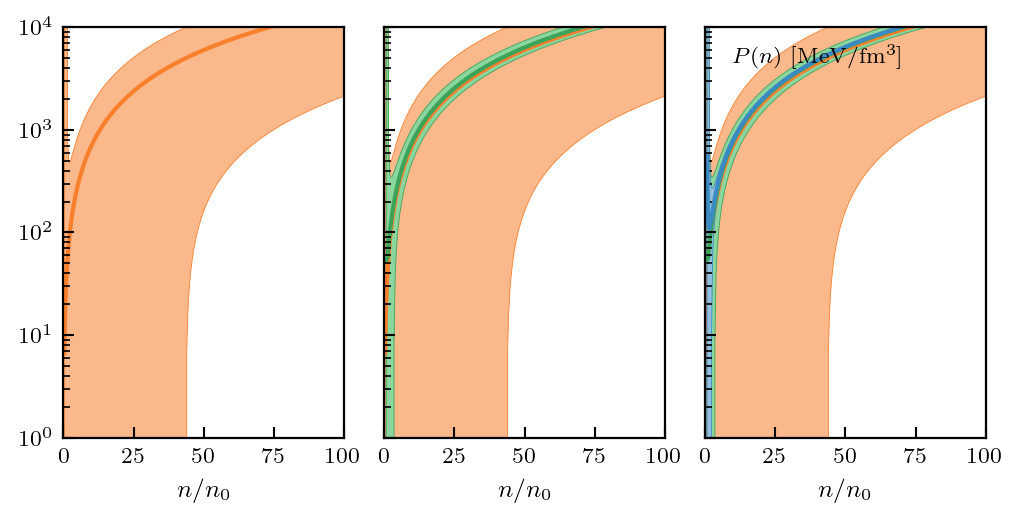

In [33]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(5, 2.5), dpi=200)
conversion = (1000)**4.0/(197.327)**3.0 

# call KLW function for pressure and assign to array
pressure_n_KLW = pqcd.pressure_KLW(mu_FG)
corrected_pressure = np.array([pressure_n_KLW["LO"], pressure_n_KLW["NLO"], pressure_n_KLW["N2LO"]]).T

for i, n in enumerate(orders):
    for j in range(i, 3):
        ax = axes.ravel()[j]
        ax.set_xlim(0.0, 100.0)
        ax.set_yscale('log')
        ax.set_ylim(1.0,10000)
        ax.plot(dens/n0, corrected_pressure[:,i]*conversion, zorder=i, c=colors[i])
        ax.fill_between(dens/n0, corrected_pressure[:, i]*conversion + 1.96*std_trunc_pn[:,i]*conversion, \
                        corrected_pressure[:, i]*conversion - 1.96*std_trunc_pn[:,i]*conversion,
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.set_xlabel(r'$n/n_{0}$')
ax.text(0.1, 0.9, r'$P(n)$ [MeV/fm$^{3}$]', ha='left', va='bottom',
           transform=ax.transAxes, fontsize=8)

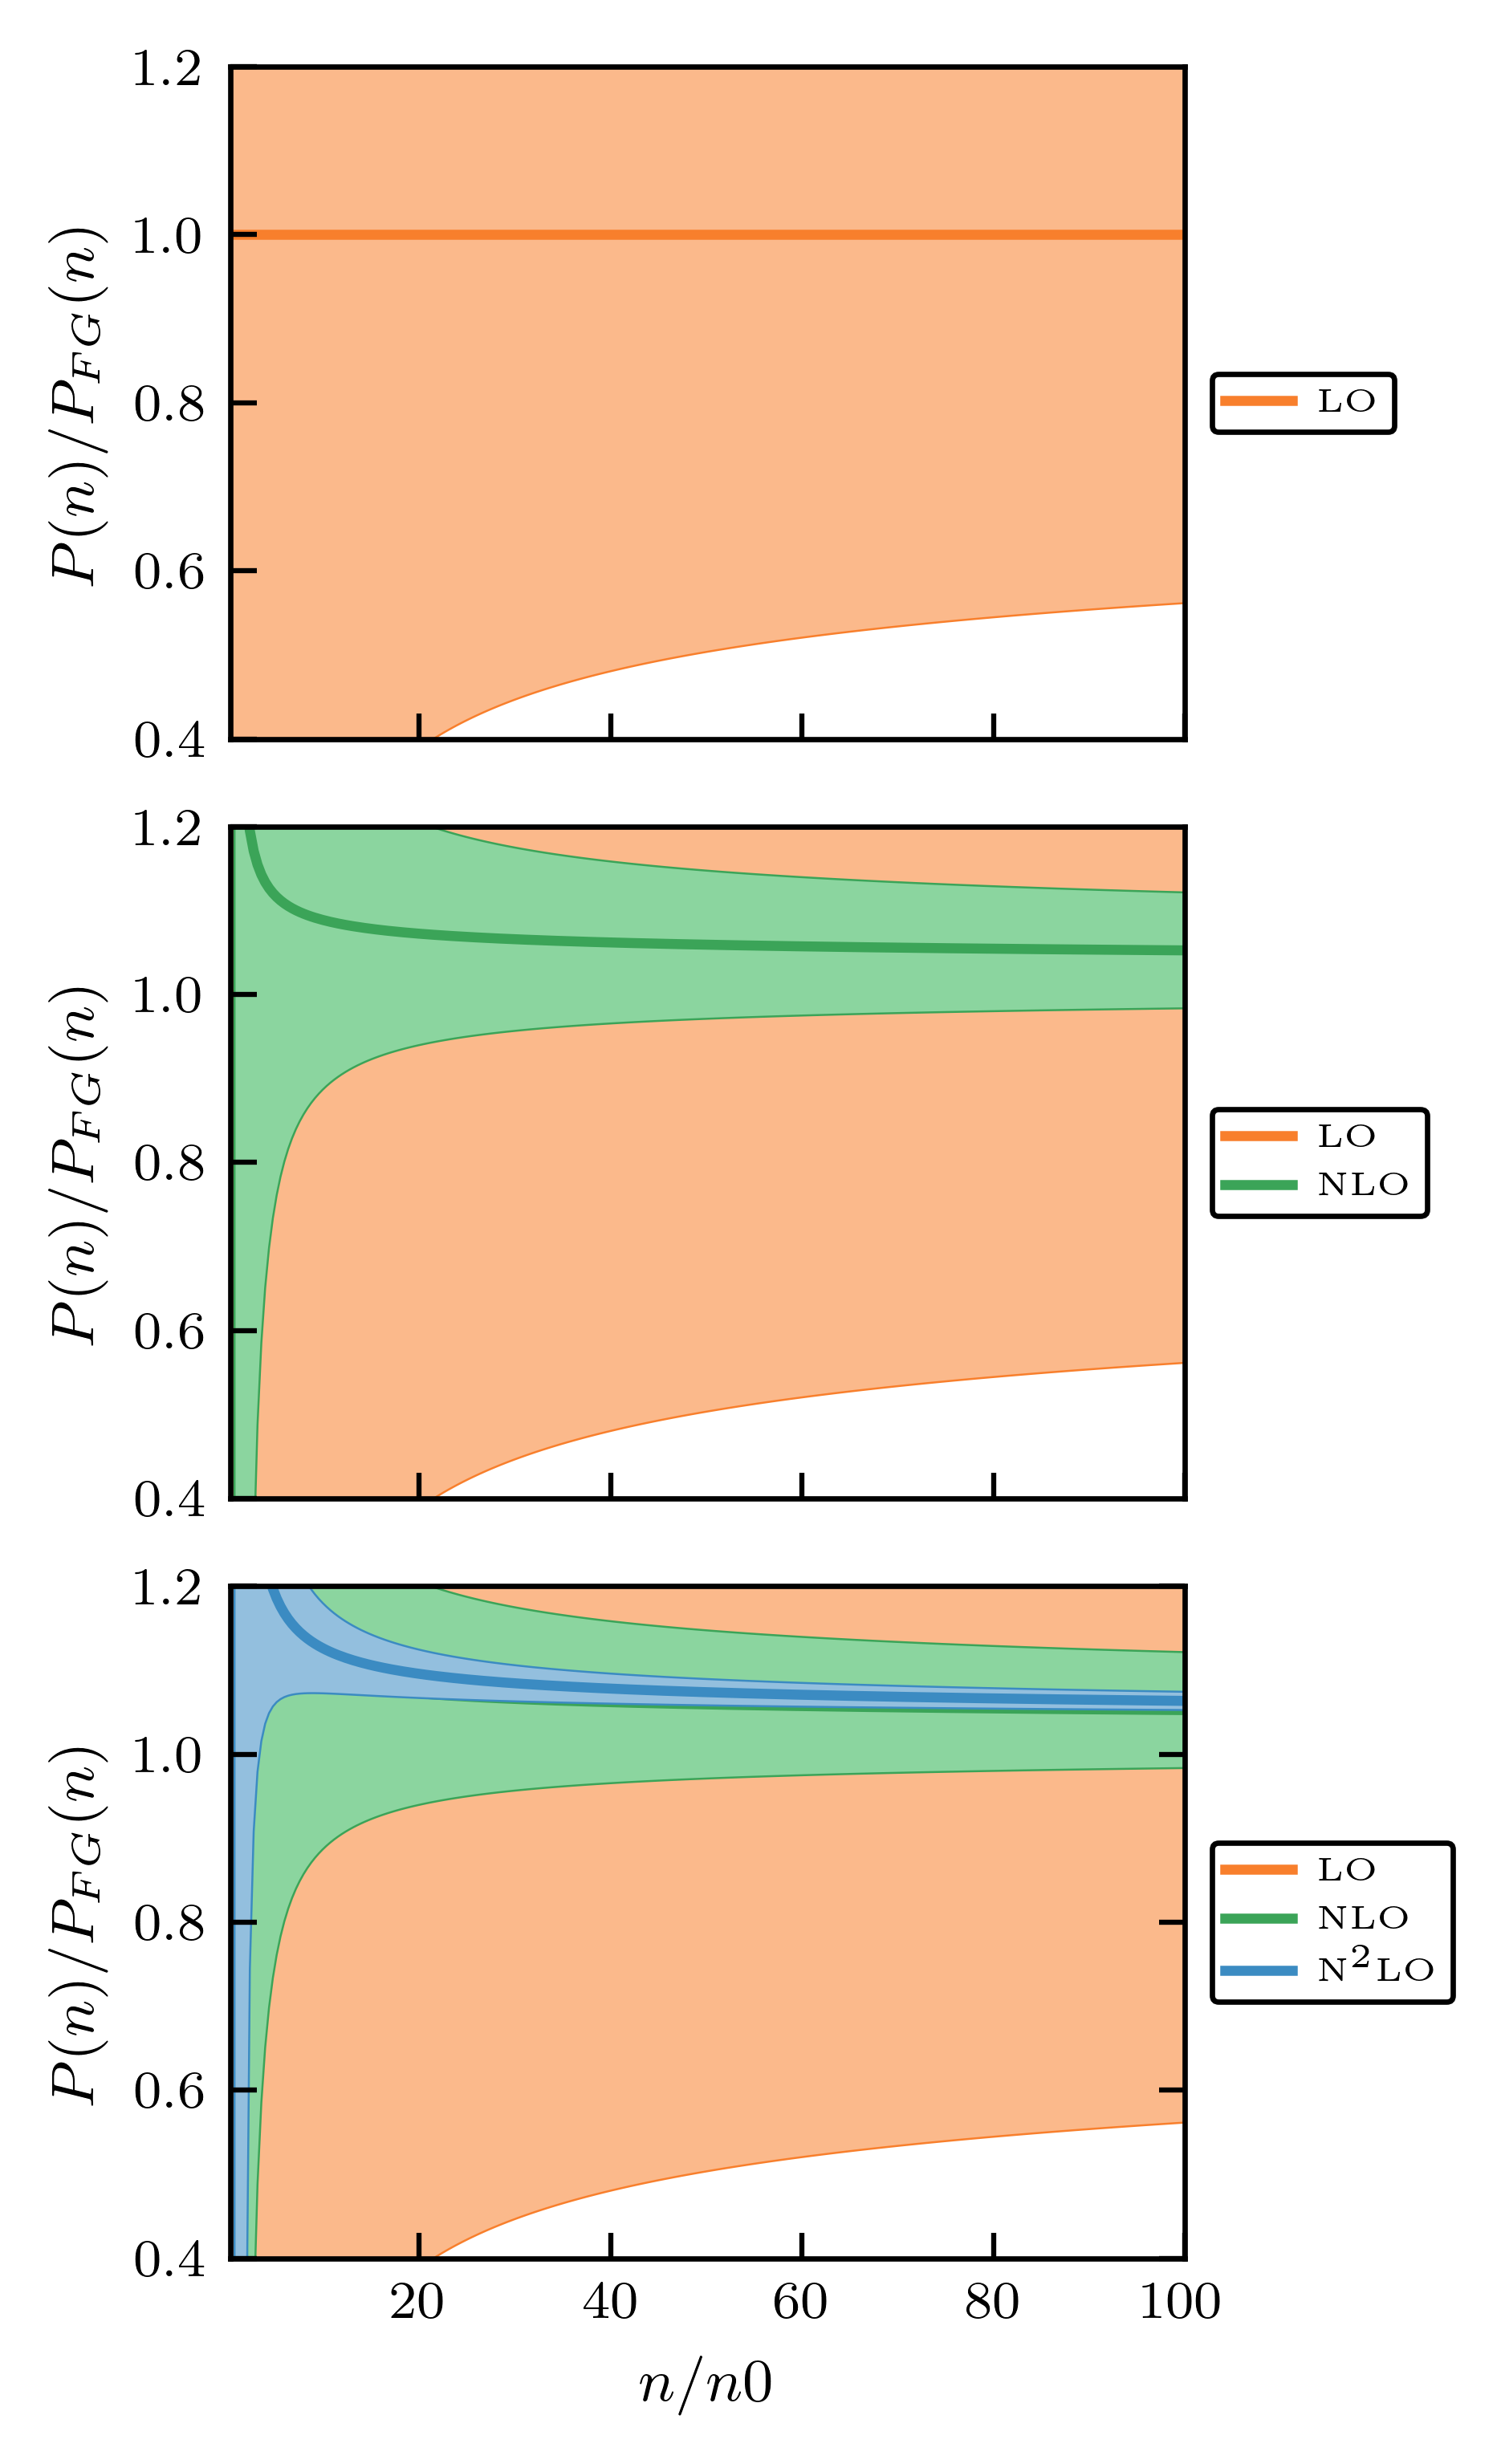

In [34]:
X = mu_n[:,None]
X_FG = mu_FG[:,None]  
labels = [r'LO', r'NLO', r'N$^{2}$LO']
labels_original = [r'LO original', r'NLO original', r'N$^{2}$LO original']

fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(3,5), dpi=600)

for i,n in enumerate(orders):
    for j in range(i, 3):
        ax = axes.ravel()[j]
        ax.plot(dens/n0, corrected_pressure[:, i]/pqcd.yref(X_FG), zorder=i-1, c=colors[i], label=labels[i])
        ax.fill_between(dens/n0, (corrected_pressure[:, i] + 1.0*std_trunc_pn[:,i])/pqcd.yref(X_FG),\
                        (corrected_pressure[:, i] - 1.0*std_trunc_pn[:,i])/pqcd.yref(X_FG),
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=5)
    ax = axes.ravel()[i]
    ax.set_ylim(0.4,1.2)
    ax.set_xlim(min(dens)/n0, max(dens)/n0)
    ax.set_ylabel(r'$P(n)/P_{FG}(n)$')
ax.set_xlabel(r'$n/n0$')
ax.tick_params(right=True)

#print(std_trunc_pn[:,2])

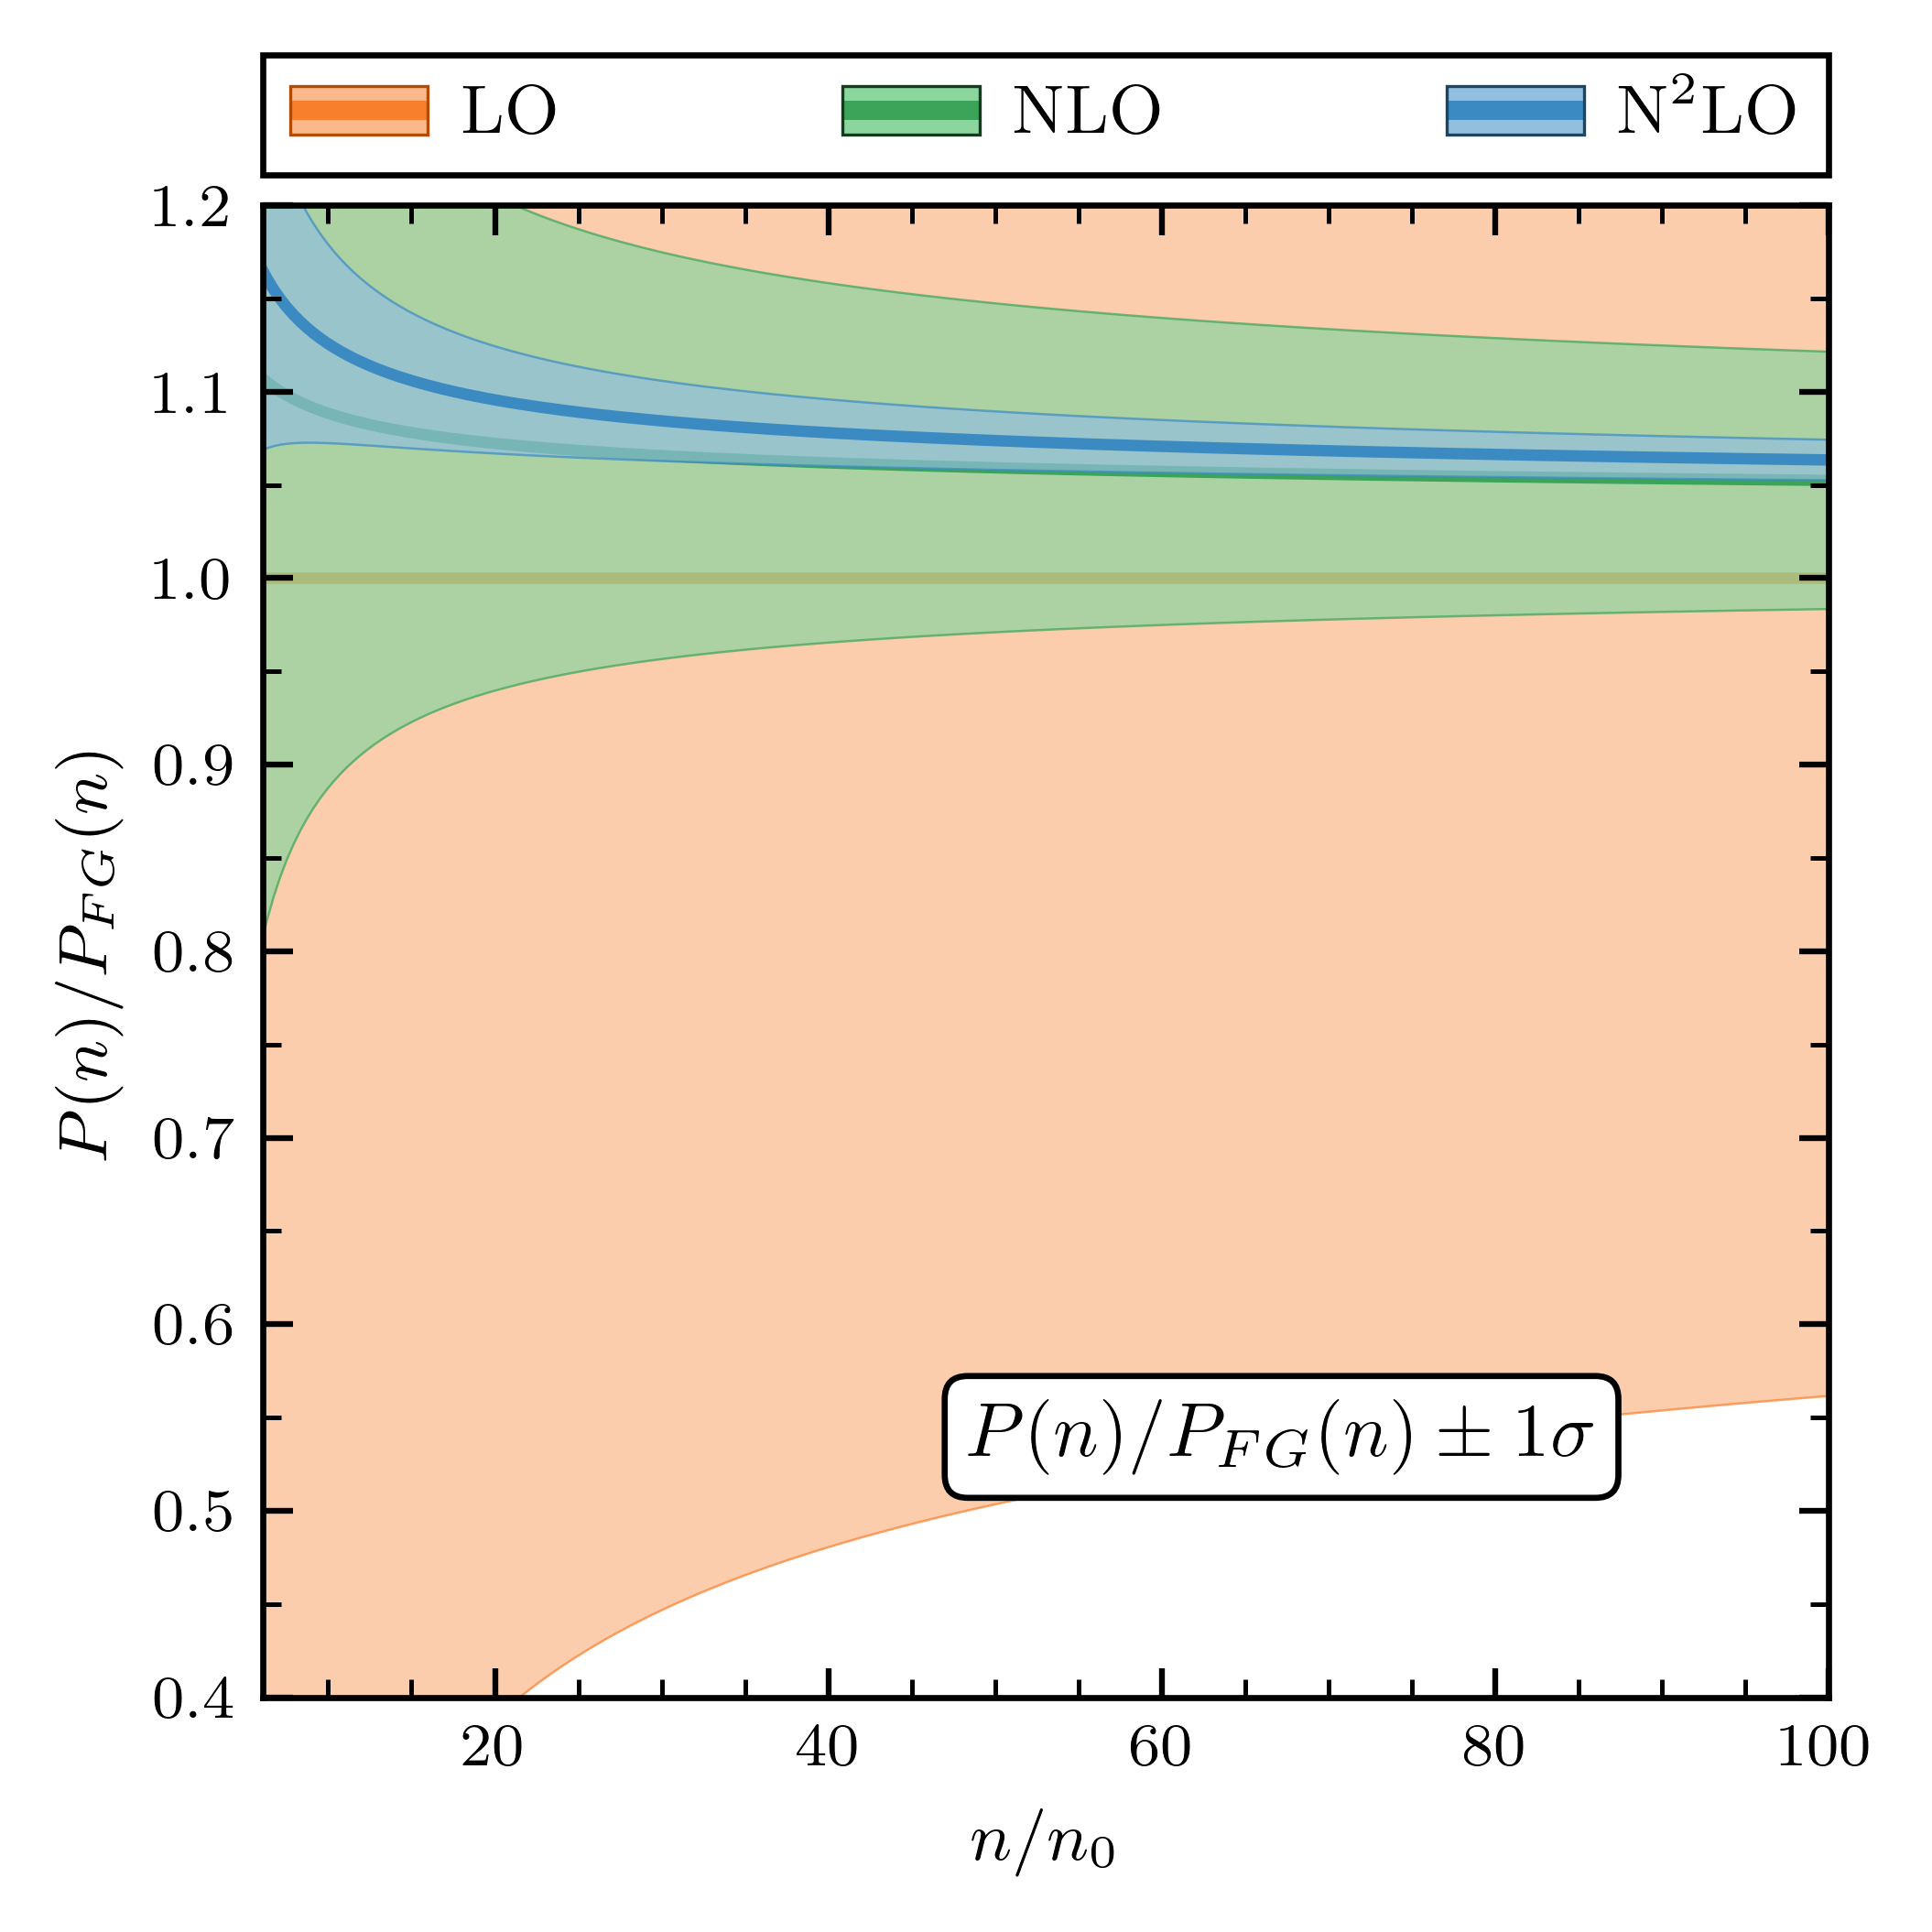

In [35]:
# Fig. 4 in our paper
X = mu_n[:,None]
X_FG = mu_FG[:,None]
labels = [r'LO', r'NLO', r'N$^{2}$LO']
labels_original = [r'LO original', r'NLO original', r'N$^{2}$LO original']

fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
for i in range(3):
    ax.plot(dens/n0, corrected_pressure[:, i]/pqcd.yref(X_FG), zorder=i-1, c=colors[i], label=labels[i])
    ax.fill_between(dens/n0, (corrected_pressure[:, i] + 1.0*std_trunc_pn[:,i])/pqcd.yref(X_FG), \
                    (corrected_pressure[:, i] - 1.0*std_trunc_pn[:,i])/pqcd.yref(X_FG),
                    zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=0.7)
    ax.set_ylim(0.4,1.2)
    ax.set_xlim(1.0/n0, max(dens)/n0)
    ax.set_ylabel(r'$P(n)/P_{FG}(n)$')
ax.set_xlabel(r'$n/n_{0}$')
title = r'$P(n)/P_{FG}(n) \pm 1\sigma$'
ax.text(
    0.45, 0.2, title, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, top=True, which='both')
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors, )
#fig.savefig('pqcd_pressure_n.png')

In [36]:
# store the P_FG(n) values, unscaled, for use in BMM later
pressure_FG = pqcd.yref(mU_FG)*conversion

#write this to a file (uncomment to save)
# if dens.size >= 600:
#     np.savez('../data/eos_data/pqcd_fg_data', density=dens, dens_scaled=dens/n0, mean=pressure_FG)
# else:
#     print('Not saved.')

In [37]:
# save scaled results in an npz file
mean_pressure_scaled = np.zeros([len(dens), 3])
std_pressure_scaled = np.zeros([len(dens), 3])
cov_pressure_scaled = np.zeros([len(dens), len(dens), 3])

scale = pqcd.yref(X_FG)

for i in range(3):
    mean_pressure_scaled[:,i] = corrected_pressure[:,i]/pqcd.yref(X_FG)
    std_pressure_scaled[:,i] = std_trunc_pn[:,i]/pqcd.yref(X_FG)

for i in range(3):
    for j in range(len(dens)):
        for k in range(len(dens)):
            cov_pressure_scaled[j,k,i] = cov_trunc_pn[j,k,i]/(scale[j]*scale[k])

#write this to a file (uncomment to save)
# if dens.size >= 600:
#     np.savez('../data/eos_data/pressure_pqcd_data_scaled', density=dens, dens_scaled=dens/n0, mean=mean_pressure_scaled, std_dev=std_pressure_scaled, \
#              cov=cov_pressure_scaled)
#     # open the file here and check it
#     npzfile = np.load('../data/eos_data/pressure_pqcd_data_scaled.npz')
#     npzfile.files

#     print(npzfile['density'].shape, npzfile['dens_scaled'].shape, npzfile['mean'].shape, npzfile['std_dev'].shape, npzfile['cov'].shape)

#     print(np.sqrt(np.diag(cov_pressure_scaled[:,:,2])) - std_pressure_scaled[:,2])
# else:
#     print('Not saved.')

In [38]:
# print the whole thing
print('Results at 100*n0:')
print('LO:',(corrected_pressure[:, 0]/pqcd.yref(X_FG))[-1])
print('NLO:',(corrected_pressure[:, 1]/pqcd.yref(X_FG))[-1])
print('N2LO:',(corrected_pressure[:, 2]/pqcd.yref(X_FG))[-1]) 

Results at 100*n0:
LO: 1.0
NLO: 1.0524516465838984
N2LO: 1.0633992078491548


Number of points in training set: 3
Number of points in validation set: 3

Training set: 
 [[0.94682731]
 [1.09461847]
 [1.24240964]]

Validation set: 
 [[0.89879518]
 [1.06506024]
 [1.2313253 ]]
2.751461923280165
1e-09
Calculated value : 4.817618091529464
Trained kernel:  RBF(length_scale=3.82)
Scale:  2.426561330287599
Condition number: 2517764.173348861


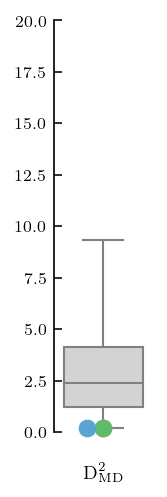

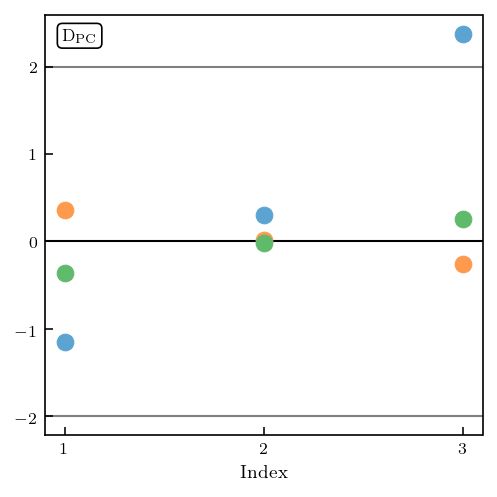

In [39]:
trunc.diagnostics(40, 45)

---

## Relative error calculation (Table I) <a id="calc_rel_err"></a>

We wish to find the place in the pQCD $P(n)$ result that matches the relative error in $\chi$EFT at the densities $1.5n_{0}$, $1.75n_{0}$, and $2n_{0}$. This is done below by importing the chiral data and comparing to the pQCD results calculated in the above sections of this notebook.

In [40]:
# import chiral EFT data
n0 = 0.164
chiral_result = np.load('../data/eos_data/pressure_chiral_data_scaled_2n0.npz')

# interpolate to obtain bands at exactly the required densities
chiral_interp = interp1d(chiral_result['density'], chiral_result['mean'][:,3], \
                         kind='cubic', fill_value='extrapolate')
chiral_low_interp = interp1d(chiral_result['density'], \
                             chiral_result['mean'][:,3]-1.0*chiral_result['std_dev'][:,3], \
                             kind='cubic', fill_value='extrapolate')
chiral_hi_interp = interp1d(chiral_result['density'], \
                            chiral_result['mean'][:,3]+1.0*chiral_result['std_dev'][:,3], \
                           kind='cubic', fill_value='extrapolate')

# evaluate exactly at required densities
chi_mean_15 = chiral_interp(1.5*n0)
chi_low_15 = chiral_low_interp(1.5*n0)
chi_hi_15 = chiral_hi_interp(1.5*n0)

chi_mean_175 = chiral_interp(1.75*n0)
chi_low_175 = chiral_low_interp(1.75*n0)
chi_hi_175 = chiral_hi_interp(1.75*n0)

chi_mean_2 = chiral_interp(2.0*n0)
chi_low_2 = chiral_low_interp(2.0*n0)
chi_hi_2 = chiral_hi_interp(2.0*n0)

# store results and print
chiral_cutoff_15 = {
    'mean': chi_mean_15,
    'lower': chi_mean_15 - chi_low_15,
    'upper': chi_hi_15 - chi_mean_15
}

chiral_cutoff_15 = {
    'mean': chi_mean_15,
    'lower': chi_mean_15 - chi_low_15,
    'upper': chi_hi_15 - chi_mean_15
}


chiral_cutoff_175 = {
    'mean': chi_mean_175,
    'lower': chi_mean_175 - chi_low_175,
    'upper': chi_hi_175 - chi_mean_175
}

chiral_cutoff_2 = {
    'mean': chi_mean_2,
    'lower': chi_mean_2 - chi_low_2,
    'upper': chi_hi_2 - chi_mean_2
}

print('At 1.5*n0, chiral EFT yields the values: \n', chiral_cutoff_15)
print('\nAt 1.75*n0, chiral EFT yields the values: \n', chiral_cutoff_175)
print('\nAt 2.0*n0, chiral EFT yields the values: \n', chiral_cutoff_2)

# now we compare to pQCD EOS values
# print relative error there
rel_err_15 = chiral_cutoff_15['upper']/chiral_cutoff_15['mean']
rel_err_175 = chiral_cutoff_175['upper']/chiral_cutoff_175['mean']
rel_err_2 = chiral_cutoff_2['upper']/chiral_cutoff_2['mean']

print('\nRelative error at 1.5n0: ', rel_err_15, 'and % error: ', rel_err_15*100.)
print('Relative error at 1.75n0: ', rel_err_175, 'and % error: ', rel_err_175*100.)
print('Relative error at 2.0n0: ', rel_err_2, 'and % error: ', rel_err_2*100.)

pqcd_rel_interp = interp1d(dens[12:], std_trunc_pn[12:, 2]/corrected_pressure[12:,2], \
                           kind='cubic', fill_value='extrapolate')
# pqcd_rel_interp = interp1d(dens[70:], std_trunc_pn[70:, 2]/corrected_pressure[70:,2], \
#                            kind='cubic', fill_value='extrapolate')  # for X = 0.5, x0 = 3.0
pqcd_rel_dens_15 = fsolve(lambda n : rel_err_15 - pqcd_rel_interp(n), x0 = 1.0, xtol=1e-08)[0]
pqcd_rel_dens_175 = fsolve(lambda n : rel_err_175 - pqcd_rel_interp(n), x0 = 1.0, xtol=1e-08)[0]
pqcd_rel_dens_2 = fsolve(lambda n : rel_err_2 - pqcd_rel_interp(n), x0 = 1.0, xtol=1e-08)[0]

# print the results
print('\npQCD density location for equal relative error at 1.5n0: ', pqcd_rel_dens_15, '[fm^-3]')
print('pQCD density in terms of n0: ', pqcd_rel_dens_15/n0)
print('Relative error at this exact point: ', pqcd_rel_interp(pqcd_rel_dens_15))
print(pqcd_rel_interp(pqcd_rel_dens_15))
print(rel_err_15 - pqcd_rel_interp(pqcd_rel_dens_15))

print('\npQCD density location for equal relative error at 1.75n0: ', pqcd_rel_dens_175, '[fm^-3]')
print('pQCD density in terms of n0: ', pqcd_rel_dens_175/n0)
print('Relative error at this exact point: ', pqcd_rel_interp(pqcd_rel_dens_175))
print(pqcd_rel_interp(pqcd_rel_dens_175))
print(rel_err_175 - pqcd_rel_interp(pqcd_rel_dens_175))

print('\npQCD density location for equal relative error at 2.0n0: ', pqcd_rel_dens_2, '[fm^-3]')
print('pQCD density in terms of n0: ', pqcd_rel_dens_2/n0)
print('Relative error at this exact point: ', pqcd_rel_interp(pqcd_rel_dens_2))
print(pqcd_rel_interp(pqcd_rel_dens_2))
print(rel_err_2 - pqcd_rel_interp(pqcd_rel_dens_2))

At 1.5*n0, chiral EFT yields the values: 
 {'mean': array(0.08431537), 'lower': 0.027964411907201808, 'upper': 0.027964411907201808}

At 1.75*n0, chiral EFT yields the values: 
 {'mean': array(0.13802878), 'lower': 0.0393743701549641, 'upper': 0.03937437015496417}

At 2.0*n0, chiral EFT yields the values: 
 {'mean': array(0.19208041), 'lower': 0.05316710936162547, 'upper': 0.05316710936162544}

Relative error at 1.5n0:  0.3316644813273815 and % error:  33.166448132738154
Relative error at 1.75n0:  0.2852620239151638 and % error:  28.52620239151638
Relative error at 2.0n0:  0.2767960985050287 and % error:  27.679609850502867

pQCD density location for equal relative error at 1.5n0:  0.30317063794803123 [fm^-3]
pQCD density in terms of n0:  1.8486014509026294
Relative error at this exact point:  0.33166448132738013
0.33166448132738013
1.3877787807814457e-15

pQCD density location for equal relative error at 1.75n0:  0.3677486502375955 [fm^-3]
pQCD density in terms of n0:  2.2423698185219

---

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="cs2"></a>

Analytically, this can be expressed as

$$
c_{s}^{2} = \frac{\partial P}{\partial \varepsilon} = \frac{\partial P}{\partial n}\left[\frac{\partial \varepsilon}{\partial n}\right]^{-1} = \frac{1}{\mu} \frac{\partial P}{\partial n}
$$

We can obtain both of these quantities quite easily, and we can even, instead of taking the derivative of $P$ with respect to $n$, use the logarithmic derivative form of the above equation, which reads as

$$
c_{s}^{2} = \frac{d\ln{\mu}}{d\ln{n}} = n \frac{\partial \ln\mu(n)}{\partial n}.
$$

Here, we'll need the values of $n$, $\ln\mu$, and $\frac{\partial \ln \mu}{\partial n}$, so let's check to see how convenient it is to obtain these with our new KLW inversion technique. 

For the speed of sound from the GP, we'll eventually need this expression for the energy density,

$$
\varepsilon(n) = n \left[\frac{\varepsilon(n_{i})}{n_{i}} + \int_{n_{i}}^{n}\frac{P(n')}{n'^{2}} dn' \right]
$$

where we are integrating the results from $P(n)$ KLW calculations, and using an initial density to make sure that we obtain the proper boundary condition for the integral. For us, we find that integrating backward using a boundary condition from pQCD established at $100n_{0}$ is the optimal way to do this calculation.

In [41]:
# calculate the speed of sound in the same manner as 
# done for the mixed model to find any inconsistencies
from eos_utils import speed_of_sound
import scipy.integrate as scint
import scipy.interpolate as scinterp

hbarc = 197.327 # MeV fm

# cut the pressure linspace from 0.05,16.0 to 11.48,16.4 or so
# (higher-order effects not too strong >= 70n0)
cs2_cut = np.where([i >= 11.48 for i in dens])[0][0]

In [53]:
# function to calculate the boundary condition
def boundary_conditions(dens, pres_dict, index=0): 
    
    # constants
    hbarc = 197.327 # Mev fm
    
    # unpack dictionary
    pres_FG = pres_dict['FG']
    pres_NLO = pres_dict['NLO']
    pres_N2LO = pres_dict['N2LO']
    
    # set up new dictionary for eps(n) BCs
    edens_FG = dict()
    edens_NLO = dict()
    edens_N2LO = dict()
    
    # make mu_FG array from the selected density array
    n_q = dens*3.0  # n_q [fm^-3]

    # convert to GeV^3 for mu_q
    conversion_fm3 = ((1000.0)**(3.0))/((197.33)**(3.0)) # [fm^-3]  (do the opposite of this)
    n_q = n_q/conversion_fm3  # [GeV^3]

    # invert to get mu
    _, _, mu_FG = pqcd.inversion(n_mu=n_q)  # [GeV] # these are quark chemical potentials
    mU_FG = mu_FG[:, None]
    
    # FG BCs (not the correct conversion for quarks...are we technically then assuming baryons??)
    edens_FG['mean'] = ((3.0 / (2 * np.pi**2.0)) * (3.0 * np.pi**2.0 * dens/2.0)**(4.0/3.0) * hbarc)[index]
    edens_FG['lower'] = (dens*3*1000.*mu_FG - (pres_dict_FG['mean']-pres_dict_FG['std_dev']))[index]
    edens_FG['upper'] = (dens*3*1000.*mu_FG - (pres_dict_FG['mean']+pres_dict_FG['std_dev']))[index]
    
    # NLO BCs
    edens_NLO['mean'] = ((pqcd.mu_1(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                         (pres_dict_NLO['mean'] - pres_dict_FG['mean']))[index]
    edens_NLO['lower'] = ((pqcd.mu_1(mU_FG)[:,0]*1000.) * 3.0 * dens \
    - ((pres_dict_NLO['mean'] - pres_dict_FG['mean']) - \
       (pres_dict_NLO['std_dev']-pres_dict_FG['std_dev'])))[index]
    edens_NLO['upper'] = ((pqcd.mu_1(mU_FG)[:,0]*1000.) * 3.0 * dens \
    - ((pres_dict_NLO['mean'] - pres_dict_FG['mean']) + \
       (pres_dict_NLO['std_dev']-pres_dict_FG['std_dev'])))[index]
    
    # N2LO BCs
    edens_N2LO['mean'] = ((pqcd.mu_2(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                          (pres_dict_N2LO['mean'] - pres_dict_NLO['mean']))[index]
    
    edens_N2LO['lower'] = ((pqcd.mu_2(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                           ((pres_dict_N2LO['mean'] - pres_dict_NLO['mean']) - \
                            (pres_dict_N2LO['std_dev']-pres_dict_NLO['std_dev'])))[index]
   
    edens_N2LO['upper'] = ((pqcd.mu_2(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                           ((pres_dict_N2LO['mean'] - pres_dict_NLO['mean']) + \
                            (pres_dict_N2LO['std_dev']-pres_dict_NLO['std_dev'])))[index]
        
    # add corrections to single out each order
    edens_NLO['mean'] += edens_FG['mean']
    edens_NLO['lower'] += edens_FG['lower']
    edens_NLO['upper'] += edens_FG['upper']
    
    edens_N2LO['mean'] += edens_NLO['mean']
    edens_N2LO['lower'] += edens_NLO['lower']
    edens_N2LO['upper'] += edens_NLO['upper']

    # combine into dictionary and return
    edens_dict = {
        'FG': edens_FG,
        'NLO': edens_NLO,
        'N2LO': edens_N2LO
    }
    
    return mu_FG, mU_FG, edens_dict

In [54]:
# dictionary of dictionary of pressures
pres_dict_FG = {
    'mean': corrected_pressure[cs2_cut:,0]*conversion,
    'std_dev': std_trunc_pn[cs2_cut:,0]*conversion
}
pres_dict_NLO = {
    'mean': corrected_pressure[cs2_cut:,1]*conversion,
    'std_dev': std_trunc_pn[cs2_cut:,1]*conversion
}

pres_dict_N2LO = {
    'mean': corrected_pressure[cs2_cut:,2]*conversion,
    'std_dev': std_trunc_pn[cs2_cut:,2]*conversion
}

# total dictionary of dictionaries
pres_dict = {
    'FG': pres_dict_FG,
    'NLO': pres_dict_NLO,
    'N2LO': pres_dict_N2LO
}

# run the boundary condition function
mu_cs2_FG, mU_cs2_FG, edens_dict = boundary_conditions(dens[cs2_cut:], pres_dict, index=-1)
print('Boundary condition values for BMM later: \n', edens_dict['N2LO'])

# run speed of sound and plot
dens_cs2, cs2_FG, cs2_log_FG, edens_FG, mu_cs2_FG = \
speed_of_sound(dens[cs2_cut:], pres_dict_FG, edens_dict['FG'], integrate='backward')
_, cs2_NLO, cs2_log_NLO, edens_NLO, mu_cs2_NLO = \
speed_of_sound(dens[cs2_cut:], pres_dict_NLO, edens_dict['NLO'], integrate='backward')
_, cs2_N2LO, cs2_log_N2LO, edens_N2LO, mu_cs2_N2LO = \
speed_of_sound(dens[cs2_cut:], pres_dict_N2LO, edens_dict['N2LO'], integrate='backward')

Boundary condition values for BMM later: 
 {'mean': 49210.54331120984, 'lower': 49374.92191587119, 'upper': 49046.16466455088}


Now we plot our results from the speed of sound calculation above.

FG endpoint: 0.3333449417021029
NLO endpoint: 0.331340837407788
N2LO endpoint 0.3257943194833956


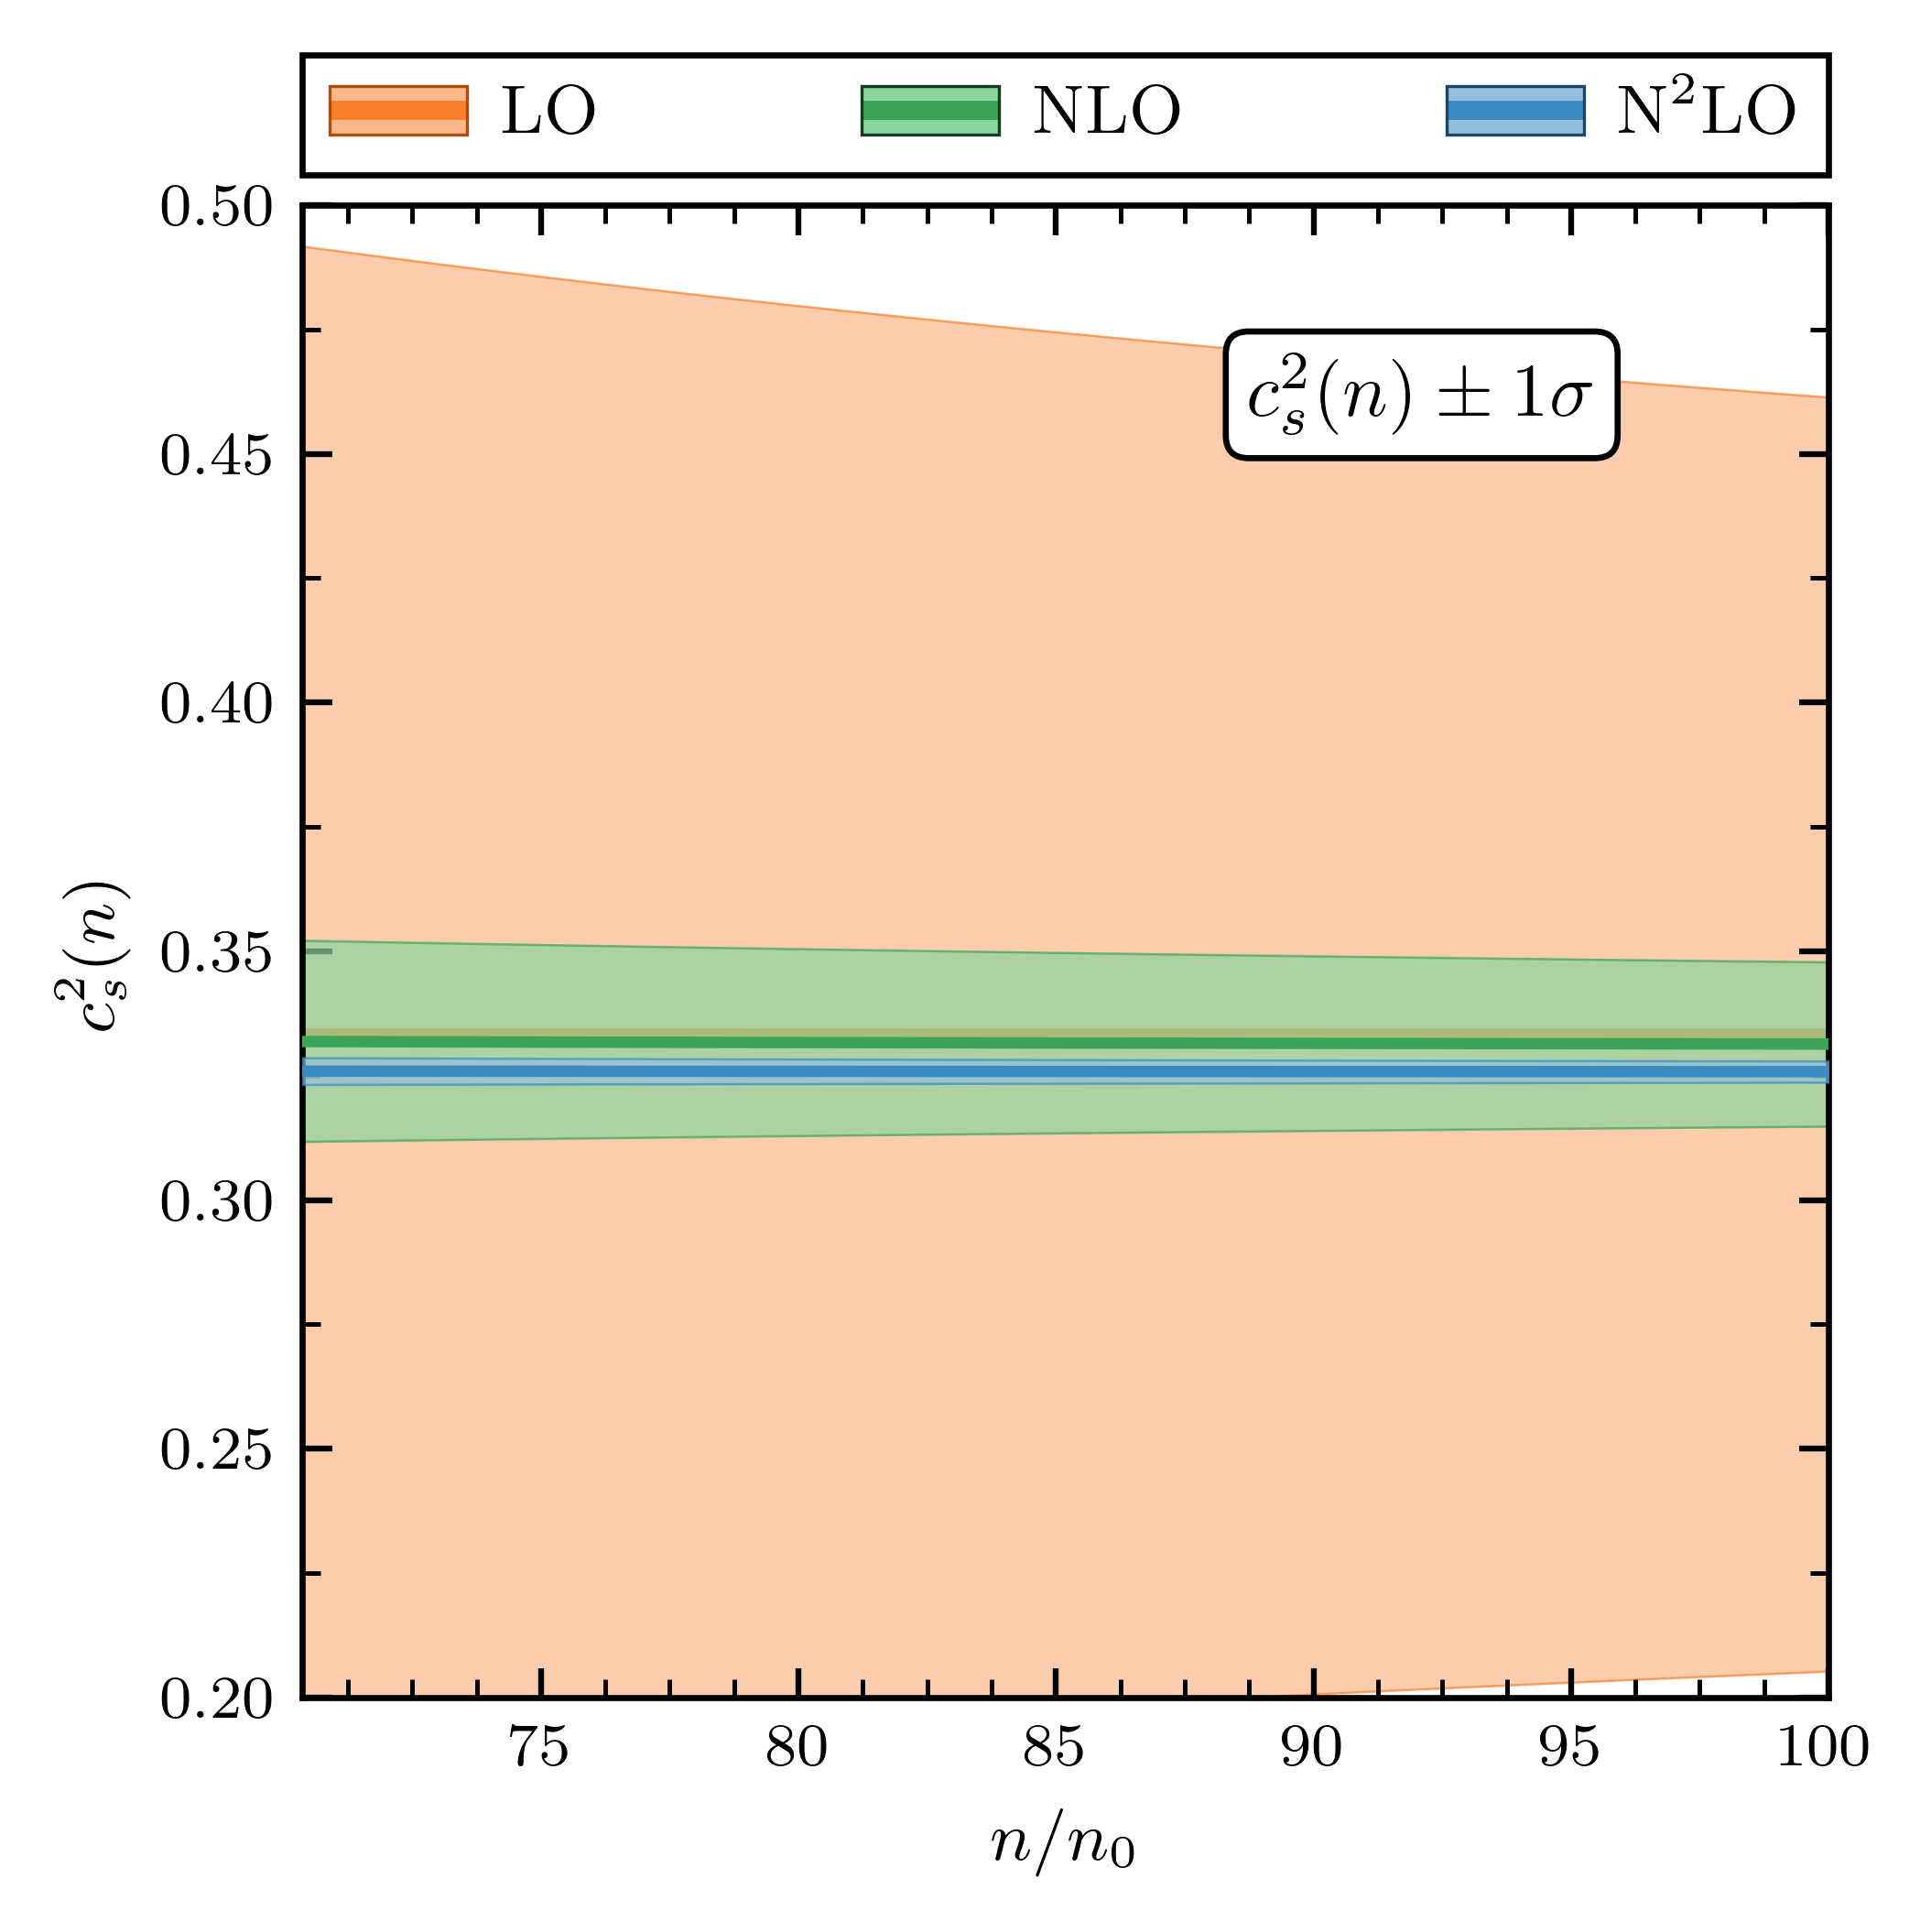

In [55]:
# Fig. 5 from our paper
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
ax.axhline(y=(1.0/3.0), color='grey', linestyle='dotted', zorder=-1, alpha=0.2)
ax.plot(dens_cs2/n0, cs2_log_FG['mean'], c=colors[0], zorder=1)
ax.fill_between(dens_cs2/n0, cs2_log_FG['lower'], cs2_log_FG['upper'],
                    zorder=0, facecolor=light_colors[0], edgecolor=colors[0], lw=edgewidth, alpha=0.7)
ax.plot(dens_cs2/n0, cs2_NLO['mean'], c=colors[1], zorder=3)
ax.fill_between(dens_cs2/n0, cs2_log_NLO['lower'], cs2_log_NLO['upper'],
                    zorder=2, facecolor=light_colors[1], edgecolor=colors[1], lw=edgewidth, alpha=0.7)
ax.plot(dens_cs2/n0, cs2_log_N2LO['mean'], c=colors[2], zorder=5)
ax.fill_between(dens_cs2/n0, cs2_log_N2LO['lower'], cs2_log_N2LO['upper'],
                    zorder=4, facecolor=light_colors[2], edgecolor=colors[2], lw=edgewidth, alpha=0.7)

ax.set_ylim(0.2,0.5)
ax.set_xlim(min(dens_cs2/n0), 100.0)
ax.set_ylabel(r'$c_{s}^{2}(n)$')
ax.set_xlabel(r'$n/n_{0}$')
title = r'$c_{s}^{2}(n) \pm 1\sigma$'
ax.text(
    0.62, 0.90, title, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, top=True, which='both')
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors)
#fig.savefig('pqcd_cs2n.png')
print('FG endpoint:', cs2_log_FG['mean'][-1])
print('NLO endpoint:', cs2_log_NLO['mean'][-1])
print('N2LO endpoint', cs2_log_N2LO['mean'][-1])

---

### Save the speed of sound data for the GP package

Now we can save this data to compare to the speed of sound calculated from the mixed model in both BMM approaches.

In [84]:
# saving speed of sound (uncomment to save)
# if dens[0] == 1.0:
#     np.savez('../data/eos_data/pqcd_cs2_1.0', density=dens, mean=cs2_N2LO['mean'], \
#              lower=cs2_N2LO['lower'], upper=cs2_N2LO['upper'])
#     # test viewing
#     npzfile = np.load('../data/eos_data/pqcd_cs2_1.0.npz')
#     npzfile.files
# elif dens[0] == 0.05:
#     np.savez('../data/eos_data/pqcd_cs2_11.2', density=dens_cs2, mean=cs2_log_N2LO['mean'], \
#              lower=cs2_log_N2LO['lower'], upper=cs2_log_N2LO['upper']) 
# else:
#     print('Not saved.')

---

Now we have completed our pQCD analysis and can move on to our pointwise and correlated model mixing approaches!

Created by: Alexandra Semposki, 
14 March 2024